In [1]:
import sys
stdout = sys.stdout
import re, math, nltk, datetime, warnings, csv
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import rcParams
import matplotlib.cm as cm
from cycler import cycler
import seaborn as sns
import itertools
from pathlib import Path
from scipy.stats import randint as sp_randint
from scipy.stats import uniform as sp_uniform
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn import preprocessing, model_selection, metrics, feature_selection
from sklearn.model_selection import GridSearchCV, learning_curve, train_test_split
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
from sklearn import neighbors, linear_model, svm, tree, ensemble
from wordcloud import WordCloud, STOPWORDS
from sklearn.ensemble import AdaBoostClassifier
from sklearn.decomposition import PCA
import lightgbm as lgb
from IPython.display import display, HTML
# import plotly.graph_objs as go
# from plotly.offline import init_notebook_mode,iplot
sys.stdout = stdout
# extension patch by intel to speed up sklearn
from sklearnex import patch_sklearn
patch_sklearn()
# init_notebook_mode(connected=True)
warnings.filterwarnings("ignore")
plt.rcParams["patch.force_edgecolor"] = True
plt.style.use('fivethirtyeight')
mpl.rc('patch', edgecolor = 'dimgray', linewidth=1)
%matplotlib inline



# configure pandas
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [2]:
print(lgb.__version__)

4.0.0


In [3]:
# load wrangled retail df
ret= pd.read_csv('/home/jk/repos/predictive-segmentation/data/online_retail_II_wrangled.csv')
print(ret.shape)
ret.head()

(417534, 8)


,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085,United Kingdom


In [4]:
# load product clusters
clusters_df = pd.read_csv('/home/jk/data/online_retail_II_product_clusters.csv')
clusters = clusters_df['0'].to_list()

# load cleaned retail df
ret_cleaned = pd.read_csv('/home/jk/repos/predictive-segmentation/data/online_retail_II_w-cleaned.csv')
descriptions = ret_cleaned['Description'].unique()

# load list_products that specifies counts of keywords across product descriptions
with open('/home/jk/data/online_retail_II_list_products.csv', 'r') as read_obj:  
    csv_read = csv.reader(read_obj)  
    list_products = list(csv_read)

In the cleaned dataset, include **cluster** membership for each product, under the column **category_prod**

In [5]:
corresp = dict()
for key, val in zip(descriptions, clusters):
    corresp[key] = val 
# # ###
ret_cleaned['category_prod'] = ret_cleaned.loc[:, 'Description'].map(corresp)

In the next step, I create variables name **category_N** (with $N \in [0:4]$), indicating the amount of money spent for each category

In [6]:
for i in range(5):
    col = 'category_{}'.format(i)        
    df_temp = ret_cleaned[ret_cleaned['category_prod'] == i]
    price_temp = df_temp['Price'] * (df_temp['Quantity'] - df_temp['QuantityCanceled'])
    price_temp = price_temp.apply(lambda x:x if x > 0 else 0)
    ret_cleaned.loc[:, col] = price_temp
    ret_cleaned[col].fillna(0, inplace = True)
#__________________________________________________________________________________________________
ret_cleaned[['Invoice', 'Description', 'category_prod', 'category_0', 'category_1', 'category_2', 'category_3','category_4']][:5]

,Invoice,Description,category_prod,category_0,category_1,category_2,category_3,category_4
0,489434,15CM CHRISTMAS GLASS BALL 20 LIGHTS,3,0.0,0.0,0.0,83.4,0.0
1,489434,PINK CHERRY LIGHTS,3,0.0,0.0,0.0,81.0,0.0
2,489434,WHITE CHERRY LIGHTS,3,0.0,0.0,0.0,81.0,0.0
3,489434,"RECORD FRAME 7"" SINGLE SIZE",4,0.0,0.0,0.0,0.0,100.8
4,489434,STRAWBERRY CERAMIC TRINKET BOX,1,0.0,30.0,0.0,0.0,0.0


Until now the retail dataframes have been organized with one row for each product of every order transaction. Below I group products by transaction order (one row for each order), making a baskets dataframe that also indicates the category composition for each basket order.

In [7]:
#___________________________________________
# sum of purchases by customer and order
temp_df = ret_cleaned.groupby(by=['Customer ID', 'Invoice'], as_index=False)['TotalPrice'].sum()
baskets = temp_df.rename(columns = {'TotalPrice':'BasketPrice'})
#____________________________________________________________
# percentage of order price by product category
for i in range(5):
    col = 'category_{}'.format(i) 
    temp = ret_cleaned.groupby(by=['Customer ID', 'Invoice'], as_index=False)[col].sum()
    baskets.loc[:, col] = temp[col]
#_____________________
# order date
ret_cleaned['InvoiceDate_int'] = pd.to_datetime(ret_cleaned['InvoiceDate']).astype(int)
temp_date = ret_cleaned.groupby(by=['Customer ID', 'Invoice'], as_index=False)['InvoiceDate_int'].mean()
ret_cleaned.drop('InvoiceDate_int', axis = 1, inplace = True)
baskets.loc[:, 'InvoiceDate'] = pd.to_datetime(temp_date['InvoiceDate_int'])
#______________________________________
# select baskets with completed orders:
baskets = baskets[baskets['BasketPrice'] > 0]
baskets.sort_values('Customer ID', ascending = True)[8:15]

,Customer ID,Invoice,BasketPrice,category_0,category_1,category_2,category_3,category_4,InvoiceDate
8,12346,495295,18.00,0.00,0.00,18.00,0.00,0.00,2010-01-22 13:30:00
9,12346,499763,27.05,0.00,0.00,3.25,23.80,0.00,2010-03-02 13:08:00
10,12346,513774,142.31,0.00,0.00,0.00,142.31,0.00,2010-06-28 13:53:00
12,12347,529924,611.53,177.58,148.50,0.00,0.00,285.45,2010-10-31 14:20:00
13,12347,537626,711.79,23.40,187.20,276.35,141.44,83.40,2010-12-07 14:57:00
14,12348,524140,222.16,151.56,69.60,0.00,0.00,1.00,2010-09-27 14:59:00
17,12349,529344,1402.62,123.60,264.42,97.30,429.25,488.05,2010-10-28 08:23:00


In [8]:
print('{0} -> {1}'.format(baskets['InvoiceDate'].min(),  baskets['InvoiceDate'].max()))

2009-12-01 07:45:00 -> 2010-12-09 20:01:00


 Split samples for training and final test sets

In [9]:
baskets_train, baskets_test = train_test_split(baskets, test_size=.20, random_state=832)
print('Set Sizes:\n  Training: {0}\n  Testing: {1}'.format(baskets_train.shape[0], baskets_test.shape[0]))

Set Sizes:
  Training: 15237
  Testing: 3810


In the next step, I use a groupby in pandas to create a dataframe of transactions_per_user. For each user, I computed the number of visits or purchase transactions, as well as the minimum, maximum, average amounts and the total amount spent during all the visits

In [10]:
#______________
# number of transactions and stats per user
transactions_per_user=baskets_train.groupby(by=['Customer ID'])['BasketPrice'].agg(['count','min','max','mean','sum'])
for i in range(5):
    col = 'category_{}'.format(i)
    transactions_per_user.loc[:,col] = baskets_train.groupby(by=['Customer ID'])[col].sum() /\
                                            transactions_per_user['sum']*100

transactions_per_user.reset_index(drop = False, inplace = True)
baskets_train.groupby(by=['Customer ID'])['category_0'].sum()
transactions_per_user.sort_values('Customer ID', ascending = True)[:5]



,Customer ID,count,min,max,mean,sum,category_0,category_1,category_2,category_3,category_4
0,12346,9,1.00,45.00,22.616667,203.55,0.000000,0.000000,88.307541,11.692459,0.000000
1,12347,2,611.53,711.79,661.660000,1323.32,15.187559,25.368014,20.883082,10.688269,27.873077
2,12348,1,222.16,222.16,222.160000,222.16,68.221102,31.328772,0.000000,0.000000,0.450126
3,12349,2,1068.52,1402.62,1235.570000,2471.14,8.255299,23.770406,6.743851,27.021537,34.208908
4,12351,1,300.93,300.93,300.930000,300.93,24.324594,34.054431,9.869405,0.000000,31.751570


Additionally, I create variables for the number of days elapsed since First and Last purchase for each user, named 'FirstPurchase' and 'LastPurchase' respectively.

In [11]:
last_date = baskets_train['InvoiceDate'].max().date()

first_registration = pd.DataFrame(baskets_train.groupby(by=['Customer ID'])['InvoiceDate'].min())
last_purchase      = pd.DataFrame(baskets_train.groupby(by=['Customer ID'])['InvoiceDate'].max())

test  = first_registration.applymap(lambda x:(last_date - x.date()).days)
test2 = last_purchase.applymap(lambda x:(last_date - x.date()).days)

transactions_per_user.loc[:, 'LastPurchase'] = test2.reset_index(drop = False)['InvoiceDate']
transactions_per_user.loc[:, 'FirstPurchase'] = test.reset_index(drop = False)['InvoiceDate']

transactions_per_user[:5]

,Customer ID,count,min,max,mean,sum,category_0,category_1,category_2,category_3,category_4,LastPurchase,FirstPurchase
0,12346,9,1.00,45.00,22.616667,203.55,0.000000,0.000000,88.307541,11.692459,0.000000,282,360
1,12347,2,611.53,711.79,661.660000,1323.32,15.187559,25.368014,20.883082,10.688269,27.873077,2,39
2,12348,1,222.16,222.16,222.160000,222.16,68.221102,31.328772,0.000000,0.000000,0.450126,73,73
3,12349,2,1068.52,1402.62,1235.570000,2471.14,8.255299,23.770406,6.743851,27.021537,34.208908,42,224
4,12351,1,300.93,300.93,300.930000,300.93,24.324594,34.054431,9.869405,0.000000,31.751570,10,10


A customer category of particular interest would be those customers who only made one purchase. You may want to target them for future promotions or ways of engaging them to make future purchases. About a third of all customers fall into this category.

In [12]:
n1 = transactions_per_user[transactions_per_user['count'] == 1].shape[0]
n2 = transactions_per_user.shape[0]
print("number of customers with a single purchase: {:<2}/{:<5} ({:<2.2f}%)".format(n1,n2,n1/n2*100))

number of customers with a single purchase: 1477/3993  (36.99%)


## Creation of Customer Segments

I select a subset of features for each customer transaction and store as a matrix. This serves as the base data for deteriming customer segements.

In [13]:
list_cols = ['count','min','max','mean','category_0','category_1','category_2','category_3','category_4']
#_____________________________________________________________
selected_customers = transactions_per_user.copy(deep = True)
matrix = selected_customers[list_cols].values

The features have wide-ranging variances, so I create a matrix where these features are standarized.

In [14]:
scaler = StandardScaler()
scaler.fit(matrix)
print('variables mean values: \n' + 90*'-' + '\n' , scaler.mean_)
scaled_matrix = scaler.transform(matrix)

variables mean values: 
------------------------------------------------------------------------------------------
 [  3.81592787 238.28246982 569.50563386 369.55563742  13.62458058
  27.20695384  15.68290226  16.06398199  27.44222021]


I perform a PCA beforehand, to provide a base of scaled_matrix represented in fewer dimensions that can be use assess the quality of seperation of the different customer segments found below.

In [15]:
pca = PCA()
pca.fit(scaled_matrix)
pca_samples = pca.transform(scaled_matrix)

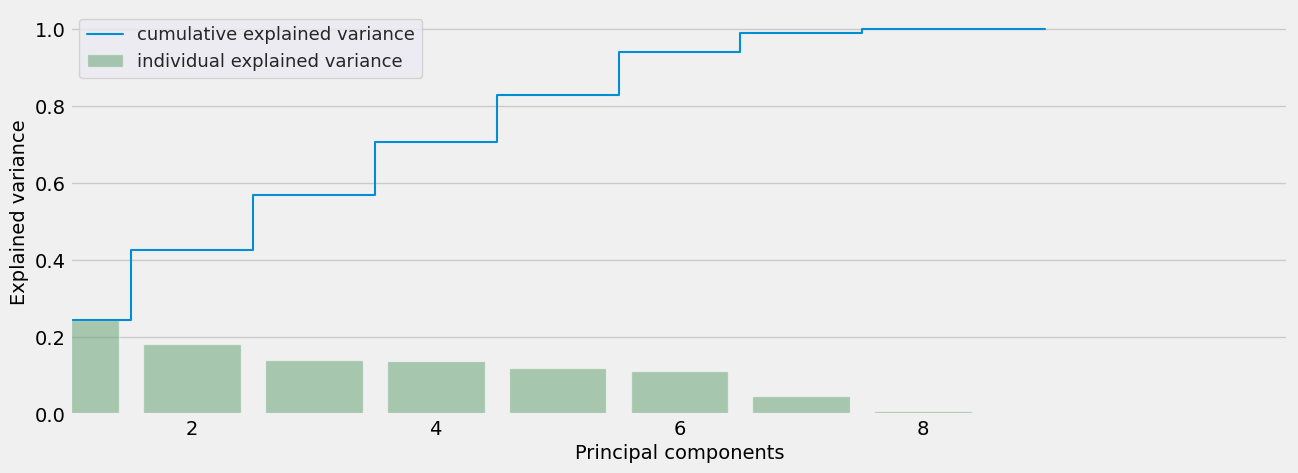

In [16]:
fig, ax = plt.subplots(figsize=(14, 5))
sns.set(font_scale=1)
plt.step(range(matrix.shape[1]), pca.explained_variance_ratio_.cumsum(), where='mid',
         label='cumulative explained variance')
sns.barplot(x=np.arange(1,matrix.shape[1]+1), y=pca.explained_variance_ratio_, alpha=0.5, color = 'g',
            label='individual explained variance')
plt.xlim(0, 10)

ax.set_xticklabels([s if int(s.get_text())%2 == 0 else '' for s in ax.get_xticklabels()])

plt.ylabel('Explained variance', fontsize = 14)
plt.xlabel('Principal components', fontsize = 14)
plt.legend(loc='best', fontsize = 13)

I create customer segments based on the scaled_matrix, using k-means clustering with intial centriods speard out according to k-means++ algorithm from scikit-learn. I determined the number of clusters based on sihoutte score. 10 clusters were used.

In [17]:
for n_clusters in range(3,13):
    kmeans = KMeans(init='k-means++', n_clusters = n_clusters, n_init=30)
    kmeans.fit(scaled_matrix)
    clusters = kmeans.predict(scaled_matrix)
    silhouette_avg = silhouette_score(scaled_matrix, clusters)
    print("For n_clusters =", n_clusters, "The average silhouette_score is :", silhouette_avg)

For n_clusters = 3 The average silhouette_score is : 0.16140922449309228
For n_clusters = 4 The average silhouette_score is : 0.1567639458367298
For n_clusters = 5 The average silhouette_score is : 0.15260397962504724
For n_clusters = 6 The average silhouette_score is : 0.1735886013349187
For n_clusters = 7 The average silhouette_score is : 0.18072040451555277
For n_clusters = 8 The average silhouette_score is : 0.18744698322254563
For n_clusters = 9 The average silhouette_score is : 0.215565792988942
For n_clusters = 10 The average silhouette_score is : 0.22416214069920587
For n_clusters = 11 The average silhouette_score is : 0.18691710099661152
For n_clusters = 12 The average silhouette_score is : 0.19337688011496407


In [18]:
n_clusters = 10
kmeans = KMeans(init='k-means++', n_clusters = n_clusters, n_init=100)
kmeans.fit(scaled_matrix)
clusters_clients = kmeans.predict(scaled_matrix)
silhouette_avg = silhouette_score(scaled_matrix, clusters_clients)
print('silhouette score: {:<.3f}'.format(silhouette_avg))

silhouette score: 0.224


In [20]:
pd.DataFrame(pd.Series(clusters_clients).value_counts(), columns = ['nb of clients']).T

,7,1,5,0,9,2,4,8,3,6
nb of clients,1902,462,443,343,334,240,222,34,10,3


There is a large disparity in the size of the clusters. So I compare the clusters across 6 principal components to verify that these customer segments provide sufficient separation.

In [21]:
pca = PCA(n_components=6)
matrix_3D = pca.fit_transform(scaled_matrix)
mat = pd.DataFrame(matrix_3D)
mat['cluster'] = pd.Series(clusters_clients)

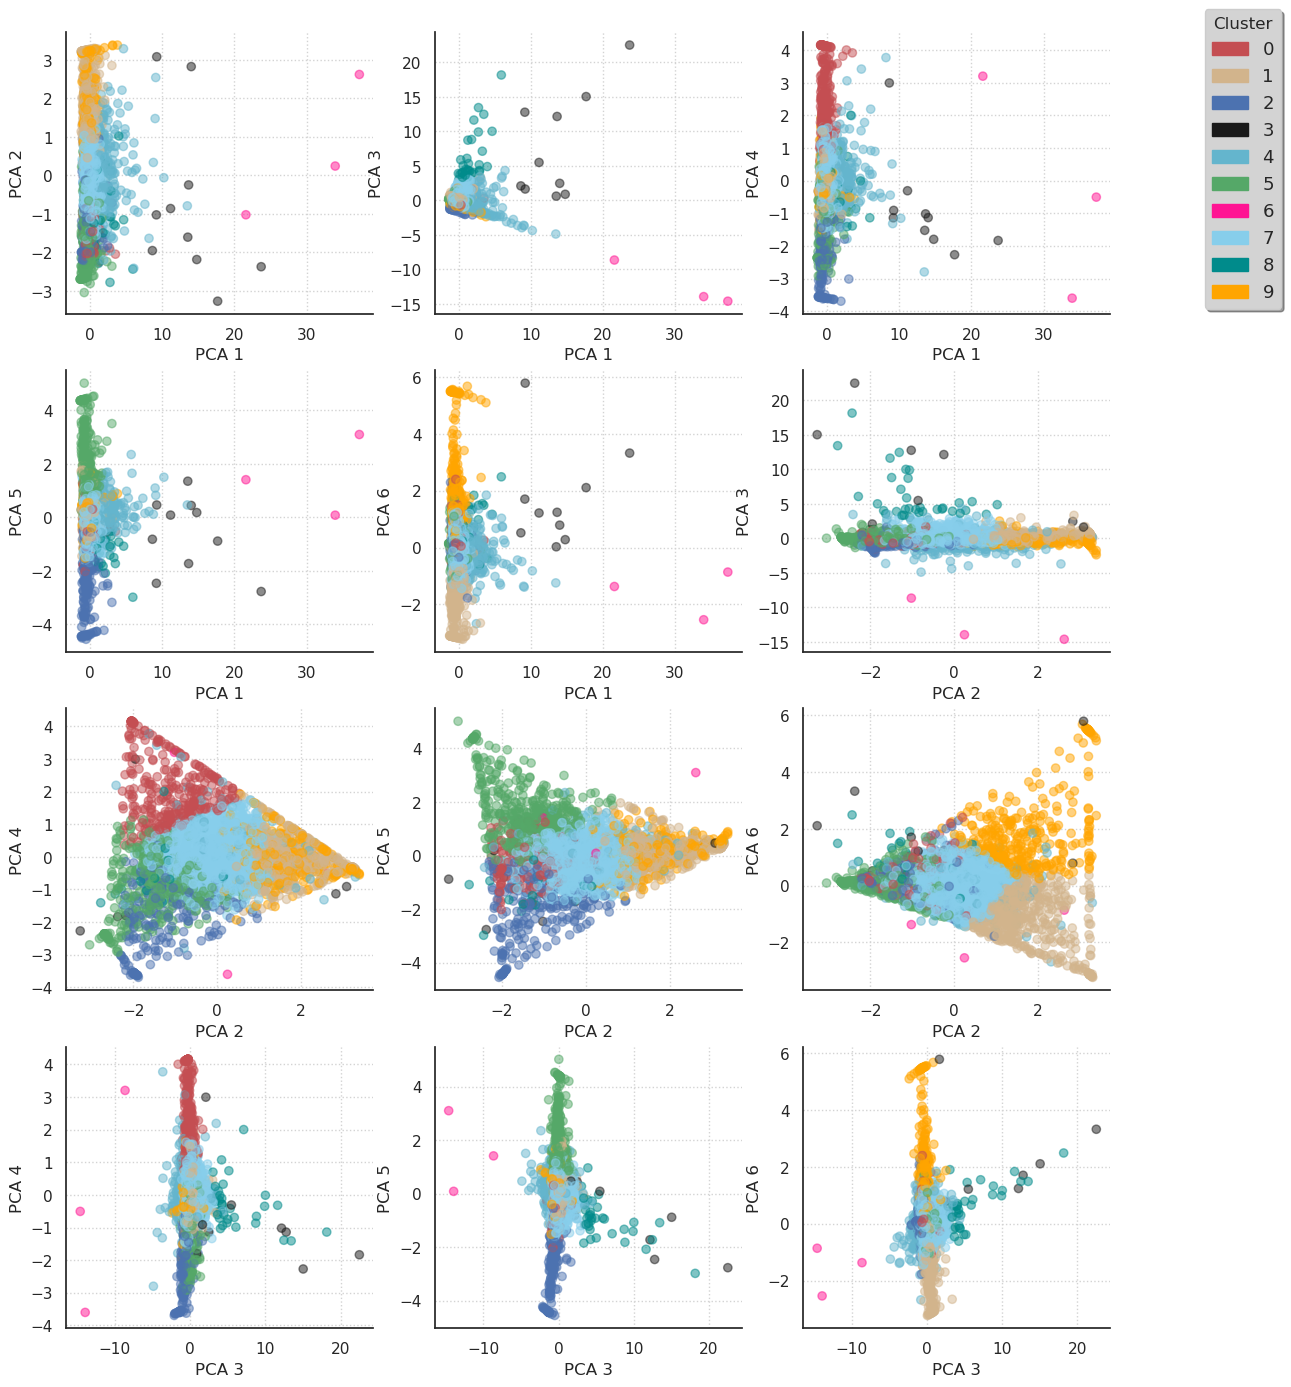

In [22]:
import matplotlib.patches as mpatches

sns.set_style("white")
sns.set_context("notebook", font_scale=1, rc={"lines.linewidth": 2.5})

LABEL_COLOR_MAP = {0:'r', 1:'tan', 2:'b', 3:'k', 4:'c', 5:'g', 6:'deeppink', 7:'skyblue', 8:'darkcyan', 9:'orange',
                   10:'yellow', 11:'tomato', 12:'seagreen'}
label_color = [LABEL_COLOR_MAP[l] for l in mat['cluster']]

fig = plt.figure(figsize = (12,16))
increment = 0
for ix in range(6):
    for iy in range(ix+1, 6):   
        increment += 1
        ax = fig.add_subplot(4,3,increment)
        ax.scatter(mat[ix], mat[iy], c= label_color, alpha=0.5) 
        plt.ylabel('PCA {}'.format(iy+1), fontsize = 12)
        plt.xlabel('PCA {}'.format(ix+1), fontsize = 12)
        ax.yaxis.grid(color='lightgray', linestyle=':')
        ax.xaxis.grid(color='lightgray', linestyle=':')
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        
        if increment == 12: break
    if increment == 12: break
        
#_______________________________________________
# I set the legend: abreviation -> airline name
comp_handler = []
for i in range(n_clusters):
    comp_handler.append(mpatches.Patch(color = LABEL_COLOR_MAP[i], label = i))

plt.legend(handles=comp_handler, bbox_to_anchor=(1.1, 0.9), 
           title='Cluster', facecolor = 'lightgrey',
           shadow = True, frameon = True, framealpha = 1,
           fontsize = 13, bbox_transform = plt.gcf().transFigure)

# plt.tight_layout()

In these plots, we see Principal component 1 sepearates the smallest clusters from the rest. Generally, at least 3 segments that are distinctly separated in each PCA representation.

## Intra-cluster Silhoutte Score

As with product clustering, we can assess the clusters by examining the within cluster silhoutte scores for each sample

In [23]:
def plot_component_silhouette(n_clusters, lim_x, mat_size, sample_silhouette_values, clusters):
    plt.rcParams["patch.force_edgecolor"] = True
    plt.style.use('fivethirtyeight')
    mpl.rc('patch', edgecolor = 'dimgray', linewidth=1)
    #____________________________
    fig, ax1 = plt.subplots(1, 1)
    fig.set_size_inches(8, 8)
    ax1.set_xlim([lim_x[0], lim_x[1]])
    ax1.set_ylim([0, mat_size + (n_clusters + 1) * 10])
    ax1.set_xlabel('Silhoutte Score')
    y_lower = 10
    for i in range(n_clusters):
        ####
        # Aggregate the silhouette scores for samples belonging to cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[clusters == i]
        ith_cluster_silhouette_values.sort()
        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i
        cmap = mpl.colormaps.get_cmap("Spectral")
        color = cmap(float(i) / n_clusters)        
        ax1.fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_silhouette_values,
                           facecolor=color, edgecolor=color, alpha=0.8)
        ####
        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.03, y_lower + 0.5 * size_cluster_i, str(i), color = 'red', fontweight = 'bold',
                bbox=dict(facecolor='white', edgecolor='black', boxstyle='round, pad=0.3'))
        ####
        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  



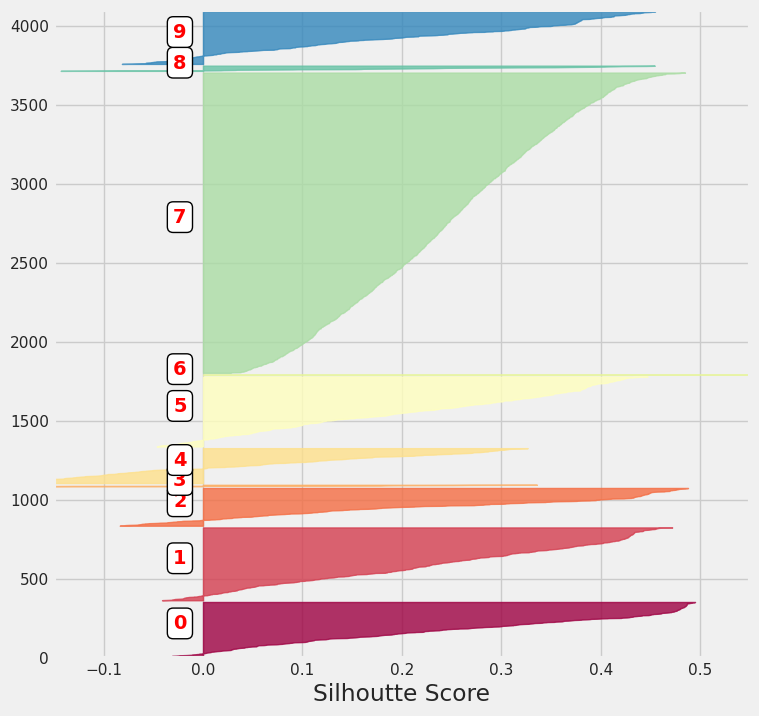

In [24]:
sample_silhouette_values = silhouette_samples(scaled_matrix, clusters_clients)
#____________________________________
# define individual silouhette scores
sample_silhouette_values = silhouette_samples(scaled_matrix, clusters_clients)
#__________________
# and make the plot
plot_component_silhouette(n_clusters, [-0.15, 0.55], len(scaled_matrix), sample_silhouette_values, clusters_clients)

I have demonstrated the customer segments based on the obtained the clusters are disjoint globally. Now I will seek to determine how these customers differ, e.g., in spending behavior perhaps. I cluster identification to the selected_customers dataframe.

In [25]:
selected_customers.loc[:, 'cluster'] = clusters_clients

Then, I select for each cluster and obtain the average for each variable, as well as size of each cluster. This provides the average baskets price, number of visits, or total sums spent by the customers of the different clusters. I also determine the number of customers in each group (variable size ).

In [26]:
merged_df = pd.DataFrame()
for i in range(n_clusters):
    test = pd.DataFrame(selected_customers[selected_customers['cluster'] == i].mean())
    test = test.T.set_index('cluster', drop = True)
    test['size'] = selected_customers[selected_customers['cluster'] == i].shape[0]
    merged_df = pd.concat([merged_df, test])
#_____________________________________________________
merged_df.drop('Customer ID', axis = 1, inplace = True)
print('number of customers:', merged_df['size'].sum())

merged_df = merged_df.sort_values('sum')

number of customers: 3993


Then, reorganized the dataframe first by amount spent for each category and then by total amount spent. 

In [27]:
list_index = []
for i in range(5):
    column = 'category_{}'.format(i)
    list_index.append(merged_df[merged_df[column] > 45].index.values[0])
#___________________________________
list_index_reordered = list_index
list_index_reordered += [ s for s in merged_df.index if s not in list_index]
#___________________________________________________________
merged_df = merged_df.reindex(index = list_index_reordered)
merged_df = merged_df.reset_index(drop = False)
display(merged_df[['cluster', 'count', 'min', 'max', 'mean', 'sum', 'category_0',
                   'category_1', 'category_2', 'category_3', 'category_4', 'size']])

,cluster,count,min,max,mean,sum,category_0,category_1,category_2,category_3,category_4,size
0,9.0,2.359281,210.321078,335.211826,268.935547,658.038982,49.055644,24.233178,7.351824,5.697539,13.673556,334
1,1.0,2.677489,189.784177,368.060498,274.922723,904.154675,11.307999,62.822605,6.423379,5.916415,13.544376,462
2,2.0,2.562500,182.175208,336.373458,252.881840,768.258917,5.022882,11.861049,57.858978,10.115168,15.141923,240
3,5.0,2.769752,194.267652,361.054266,269.912920,839.828397,5.475905,12.404553,11.777039,50.540607,19.859684,443
4,0.0,2.262391,170.431895,321.259329,239.129153,602.130117,5.818080,11.036514,7.830085,8.170948,67.170197,343
5,7.0,4.108307,199.993849,506.253057,333.768127,1452.772364,12.417910,27.366912,16.671872,14.666761,28.889903,1902
6,4.0,3.112613,861.425275,1843.441221,1243.073741,4092.179829,13.466638,28.050384,13.246586,14.466871,30.822294,222
7,6.0,1.000000,9905.396667,9905.396667,9905.396667,9905.396667,14.089579,8.746096,25.901738,1.225808,50.036779,3
8,8.0,51.323529,37.915588,1897.515029,478.656219,24039.599471,9.446076,26.378484,16.059018,17.366303,30.752559,34
9,3.0,34.100000,266.358000,17479.371000,3973.267585,93160.541000,19.525677,18.989083,13.526137,18.539664,29.419439,10


## Customer Morphology

Now, I create a representation of the customer morphologies. I define a class for making Radar Charts, adapted from previous.

In [28]:
def _scale_data(data, ranges):
    (x1, x2) = ranges[0]
    d = data[0]
    return [(d - y1) / (y2 - y1) * (x2 - x1) + x1 for d, (y1, y2) in zip(data, ranges)]

class RadarChart():
    def __init__(self, fig, location, sizes, variables, ranges, n_ordinate_levels = 6):

        angles = np.arange(0, 360, 360./len(variables))

        ix, iy = location[:] ; size_x, size_y = sizes[:]
        
        axes = [fig.add_axes([ix, iy, size_x, size_y], polar = True, 
        label = "axes{}".format(i)) for i in range(len(variables))]

        _, text = axes[0].set_thetagrids(angles, labels = variables)
        
        for txt, angle in zip(text, angles):
            if angle > -1 and angle < 181:
                txt.set_rotation(angle - 90)
            else:
                txt.set_rotation(angle - 270)
        
        for ax in axes[1:]:
            ax.patch.set_visible(False)
            ax.xaxis.set_visible(False)
            ax.grid("off")
        
        for i, ax in enumerate(axes):
            grid = np.linspace(*ranges[i],num = n_ordinate_levels)
            grid_label = [""]+["{:.0f}".format(x) for x in grid[1:]]
            ax.set_rgrids(grid, labels = grid_label, angle = angles[i])
            ax.set_ylim(*ranges[i])
        
        self.angle = np.deg2rad(np.r_[angles, angles[0]])
        self.ranges = ranges
        self.ax = axes[0]
                
    def plot(self, data, *args, **kw):
        sdata = _scale_data(data, self.ranges)
        self.ax.plot(self.angle, np.r_[sdata, sdata[0]], *args, **kw)

    def fill(self, data, *args, **kw):
        sdata = _scale_data(data, self.ranges)
        self.ax.fill(self.angle, np.r_[sdata, sdata[0]], *args, **kw)

    def legend(self, *args, **kw):
        self.ax.legend(*args, **kw)
        
    def title(self, title, *args, **kw):
        self.ax.text(0.9, 1, title, transform = self.ax.transAxes, *args, **kw)

These plots provide a global view of the customer clusters

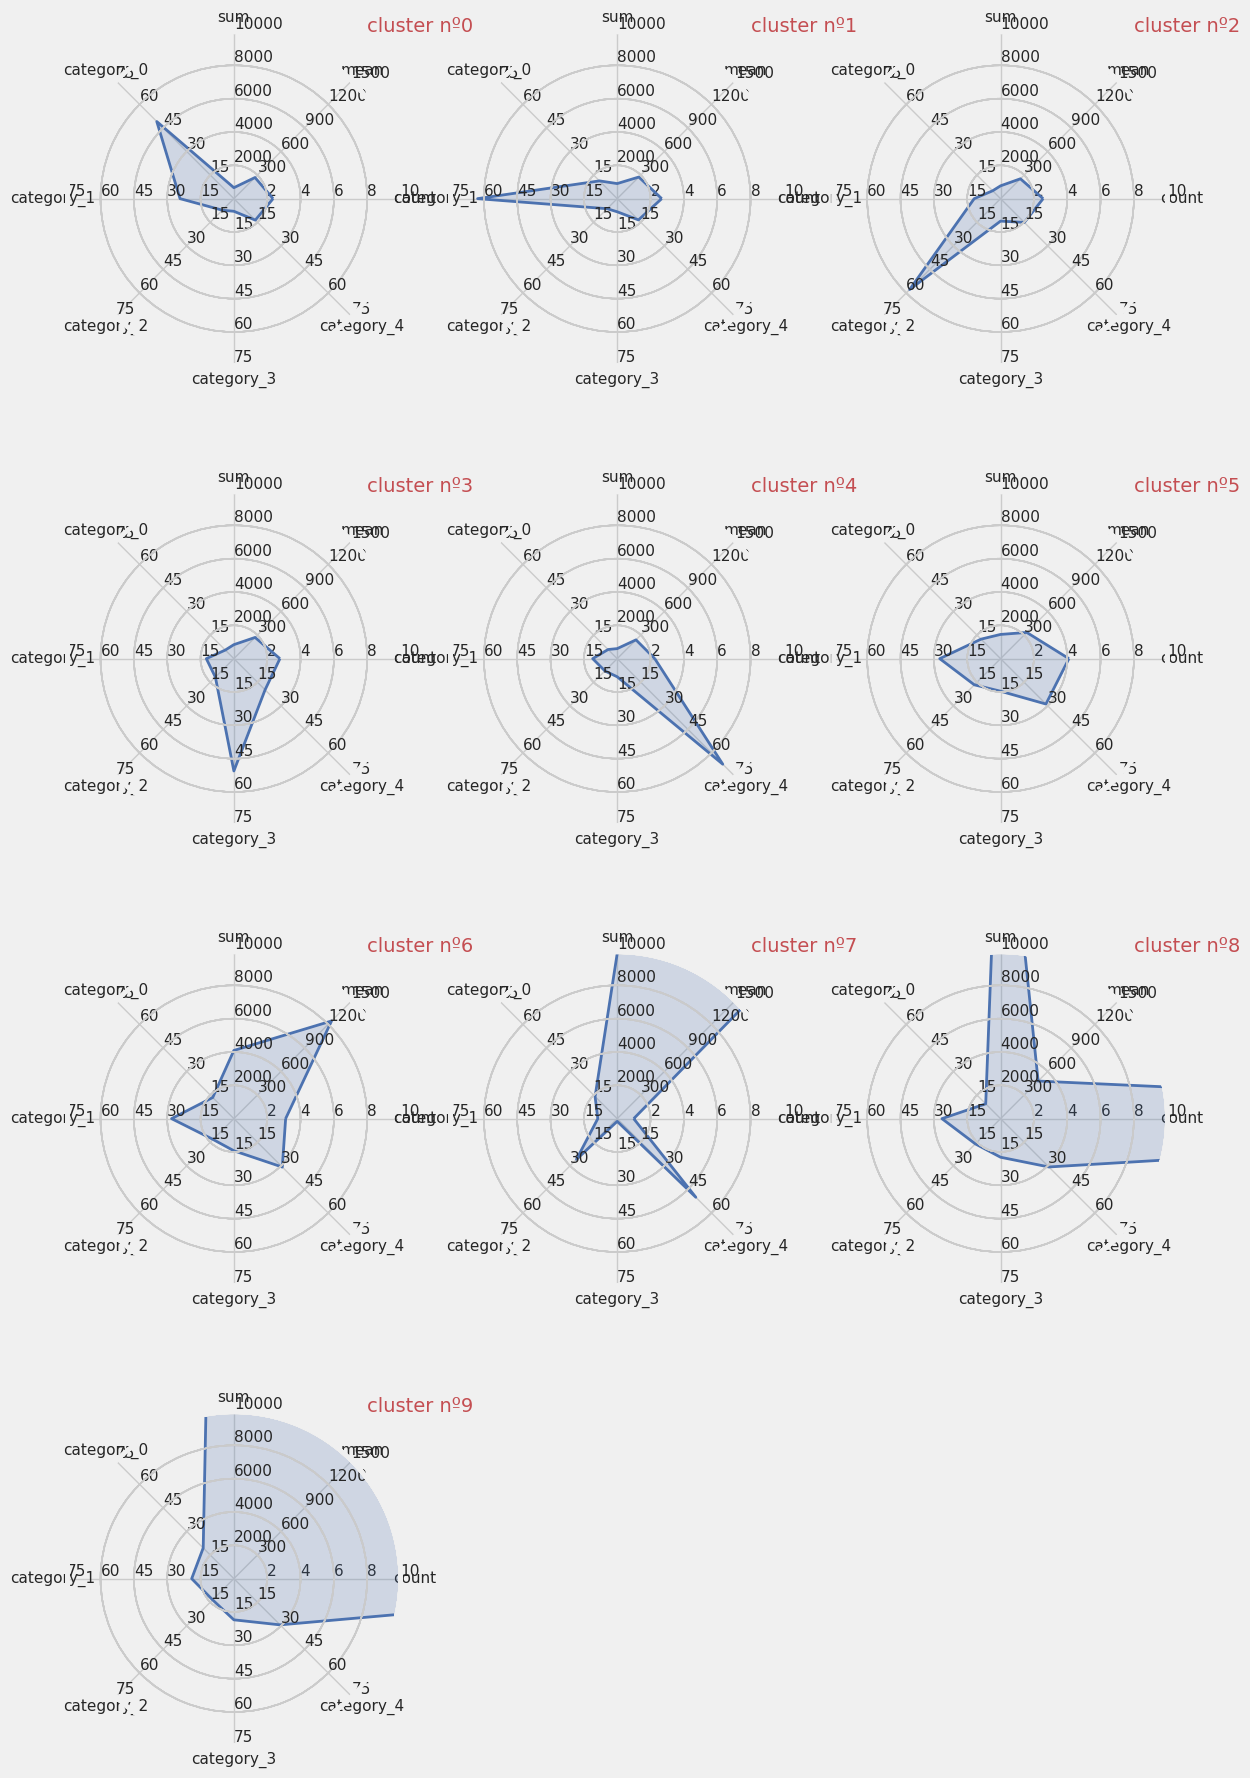

In [29]:
fig = plt.figure(figsize=(10,12))

attributes = ['count', 'mean', 'sum', 'category_0', 'category_1', 'category_2', 'category_3', 'category_4']
ranges = [[0.01, 10], [0.01, 1500], [0.01, 10000], [0.01, 75], [0.01, 75], [0.01, 75], [0.01, 75], [0.01, 75]]
index  = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]

n_groups = n_clusters ; i_cols = 3
i_rows = n_groups//i_cols
size_x, size_y = (1/i_cols), (1/i_rows)

for ind in range(n_clusters):
    ix = ind%3 ; iy = i_rows - ind//3
    pos_x = ix*(size_x + 0.05) ; pos_y = iy*(size_y + 0.05)            
    location = [pos_x, pos_y]  ; sizes = [size_x, size_y] 
    #______________________________________________________
    data = np.array(merged_df.loc[index[ind], attributes])    
    radar = RadarChart(fig, location, sizes, attributes, ranges)
    radar.plot(data, color = 'b', linewidth=2.0)
    radar.fill(data, alpha = 0.2, color = 'b')
    radar.title(title = 'cluster nº{}'.format(index[ind]), color = 'r')
    ind += 1

From these charts, we can see that the first 5 customer clusters coorespond to having a majority of their purchases from a certain product cagetory. And the others vary in basket average (**mean**), total price spent (**sum**), and/or number of visits (**count**).

## Machine Learning 
### To predict the segment that a customer belongs to based on their past purchases
* Created a class for handling various sklearn methods and functions like fit and gridsearch
* Trained multiple models and performed hyperparamter tuning with Grid Search Cross Validation
* Plotted Learning Curves and Confusion Matrices to assess models fit and performance

In [30]:
class Class_Fit(object):
    def __init__(self, clf, params=None):
        if params:            
            self.clf = clf(**params)
        else:
            self.clf = clf()

    def train(self, x_train, y_train):
        self.clf.fit(x_train, y_train)

    def predict(self, x):
        return self.clf.predict(x)
    
    def grid_search(self, parameters, Kfold):
        self.grid = GridSearchCV(estimator = self.clf, param_grid = parameters, cv = Kfold)
        
    def grid_fit(self, X, Y):
        self.grid.fit(X, Y)
        
    def grid_predict(self, X, Y):
        self.predictions = self.grid.predict(X)
        print("Precision: {:.2f} % ".format(100*metrics.accuracy_score(Y, self.predictions)))
        

Since the goal is to predict the segement that the customer belongs as early as the first purchase, I include only features that reflect the contents of the baskets and not features across visits.

In [31]:
columns = ['mean', 'category_0', 'category_1', 'category_2', 'category_3', 'category_4' ]
X = selected_customers[columns]
Y = selected_customers['cluster']

In [32]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size = 0.8, stratify=Y)

In [33]:
Y_train.value_counts()

7    1522
1     370
5     354
0     274
9     267
2     192
4     178
8      27
3       8
6       2
Name: cluster, dtype: int64

### Functions for creating Learning Curves and Confusion Matrix

In [39]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 10)):
    """Generate a simple plot of the test and training learning curve"""
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")

    plt.legend(loc="best")
    return plt

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    #_________________________________________________
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=0)
    plt.yticks(tick_marks, classes)
    #_________________________________________________
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    #_________________________________________________
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

## k-Nearest Neighbors

In [40]:
knn = Class_Fit(clf = neighbors.KNeighborsClassifier)
knn.grid_search(parameters = [{'n_neighbors': np.arange(1,50,1)}], Kfold = 2)
knn.grid_fit(X = X_train, Y = Y_train)
knn.grid_predict(X_test, Y_test)

Precision: 84.73 % 


### Learning Curves

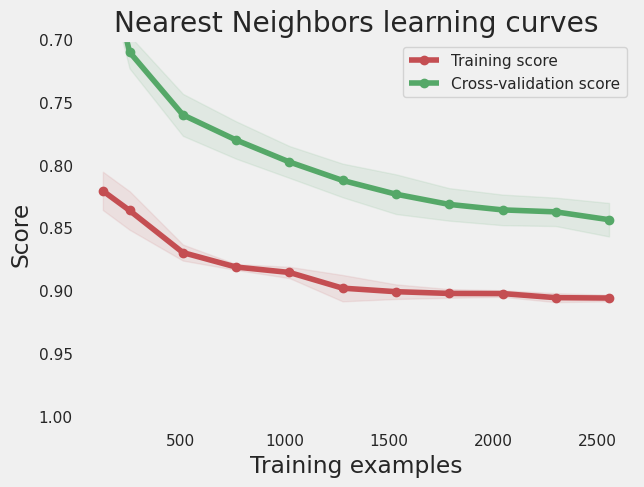

In [41]:
g = plot_learning_curve(knn.grid.best_estimator_, "Nearest Neighbors learning curves", X_train, Y_train,
                        ylim = [1.01, 0.7], cv = 5, 
                        train_sizes = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])

### Confusion Matrix

Confusion matrix, without normalization


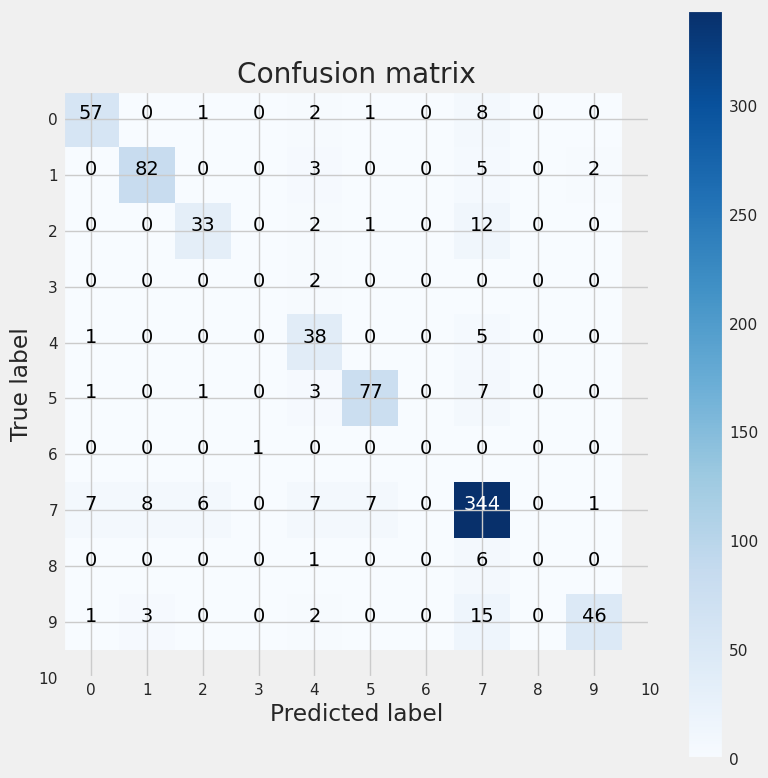

In [42]:
class_names = [i for i in range(11)]
cnf_matrix = confusion_matrix(Y_test, knn.predictions) 
np.set_printoptions(precision=2)
plt.figure(figsize = (8,8))
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize = False, title='Confusion matrix')

## Random Forest

In [43]:
rf = Class_Fit(clf = ensemble.RandomForestClassifier)
param_grid = {'criterion' : ['entropy', 'gini'], 'n_estimators' : [20, 40, 60, 80, 100],
               'max_features' :['sqrt', 'log2']}
rf.grid_search(parameters = param_grid, Kfold = 2)
rf.grid_fit(X = X_train, Y = Y_train)
rf.grid_predict(X_test, Y_test)

Precision: 94.49 % 


### Learning Curves

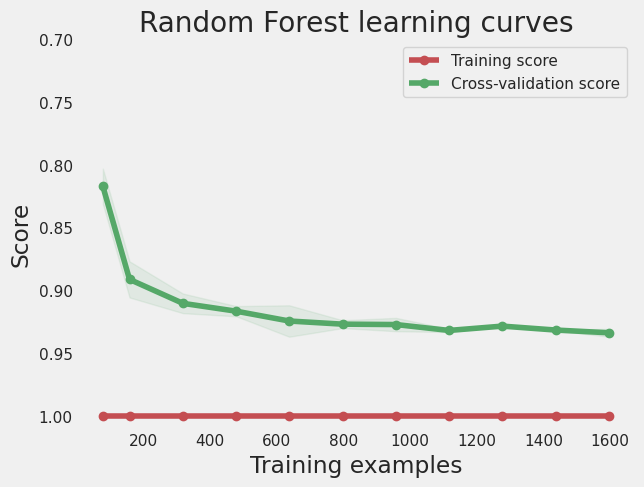

In [44]:
g = plot_learning_curve(rf.grid.best_estimator_, "Random Forest learning curves", X_train, Y_train,
                        ylim = [1.01, 0.7], cv = 2, 
                        train_sizes = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])

### Confusion Matrix

Confusion matrix, without normalization


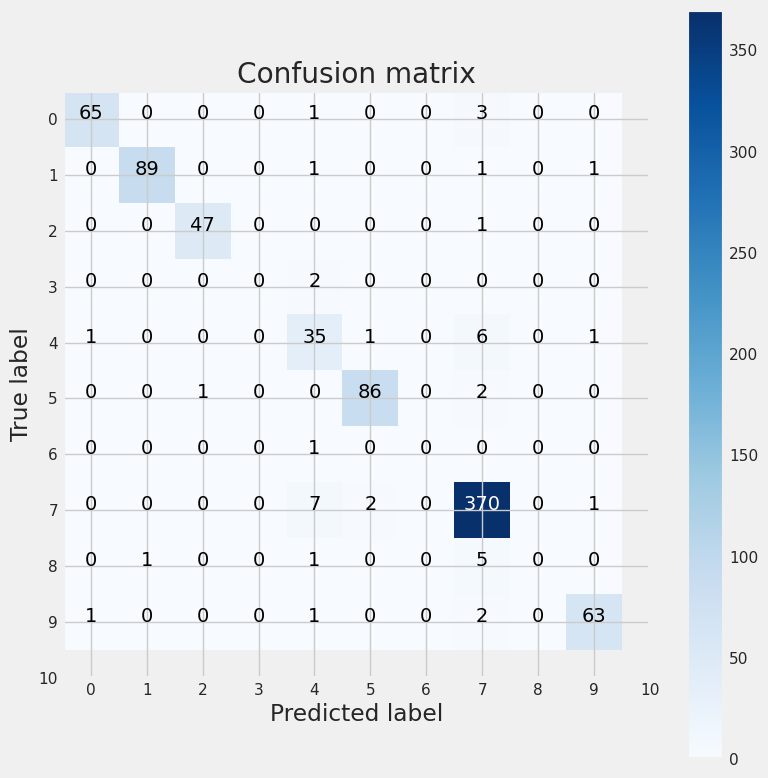

In [45]:
class_names = [i for i in range(11)]
cnf_matrix = confusion_matrix(Y_test, rf.predictions) 
np.set_printoptions(precision=2)
plt.figure(figsize = (8,8))
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize = False, title='Confusion matrix')

## Gradient Boosting Classifier

In [46]:
gb = Class_Fit(clf = ensemble.GradientBoostingClassifier)
param_grid = {'n_estimators' : [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]}
gb.grid_search(parameters = param_grid, Kfold = 2)
gb.grid_fit(X = X_train, Y = Y_train)
gb.grid_predict(X_test, Y_test)

Precision: 93.99 % 


### Learning Curves

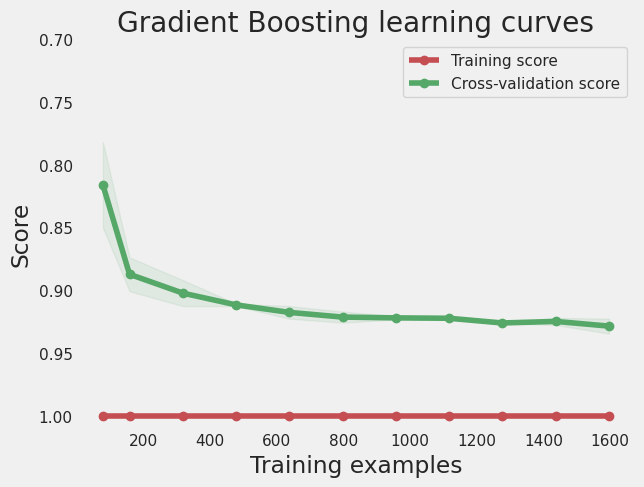

In [47]:
g = plot_learning_curve(gb.grid.best_estimator_, "Gradient Boosting learning curves", X_train, Y_train,
                        ylim = [1.01, 0.7], cv = 2, 
                        train_sizes = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])

### Confusion Matrix

Confusion matrix, without normalization


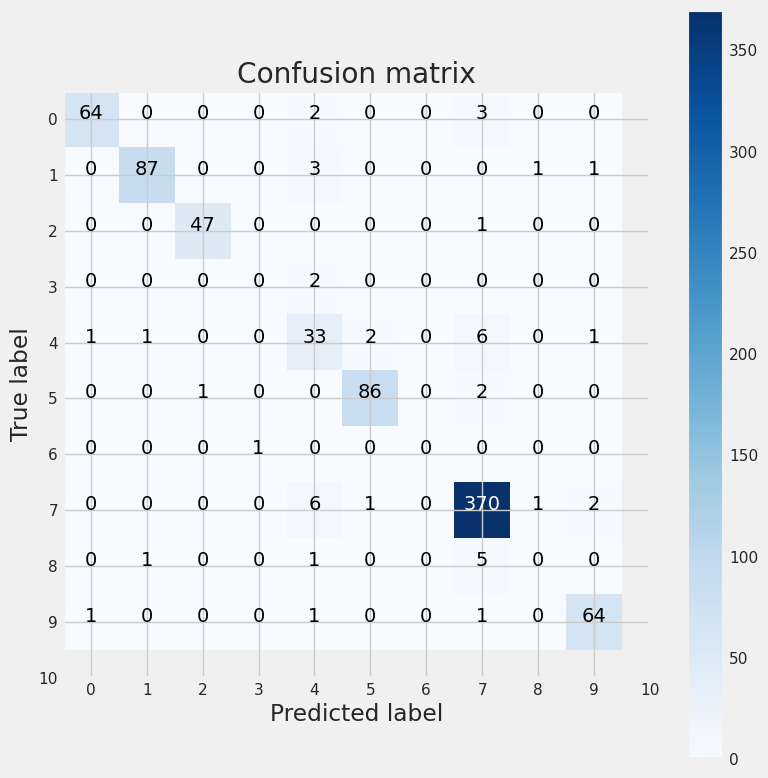

In [48]:
class_names = [i for i in range(11)]
cnf_matrix = confusion_matrix(Y_test, gb.predictions) 
np.set_printoptions(precision=2)
plt.figure(figsize = (8,8))
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize = False, title='Confusion matrix')

## Majority Vote approach to ensemble machine learning models

In [ ]:
votingC = ensemble.VotingClassifier(estimators=[('rf', rf_best),('gb', gb_best),
                                                ('knn', knn_best)], voting='soft')    

## Ensembling Algorithms by Blending Probabilities

In [ ]:
def blend_proba(clfs, blender, X, y, X_bTest, featTup, n_folds, seed, shuffle=True, verbose=True):
    dataset_blend_train = np.zeros((X.shape[0], len(clfs)))
    dataset_blend_test = np.zeros((X_bTest.shape[0], len(clfs)))
    
    skf = StratifiedKFold(n_folds, shuffle=shuffle, random_state=seed)
    j = 0
    ModNames = []
    for name, clf, colinear in clfs:
        ModNames.append(name)
        # select either (non)colinear features depending on model assumptions
        if colinear:
            x = X[featTup[0]]
            x_bTest = X_bTest[featTup[0]]
        else:
            x = X[featTup[1]]
            x_bTest = X_bTest[featTup[1]]
        dataset_blend_test_j = np.zeros((x_bTest.shape[0], n_folds))
        accuracies = np.array([])
        for i, (train, test) in enumerate(skf.split(x, y)):
            # print "Fold", i
            X_train = x.iloc[train]#.apply(featureNorm)
            y_train = y.iloc[train]
            X_test = x.iloc[test]
            y_test = y.iloc[test]
            clf.fit(X_train, y_train)
            probj = clf.predict_proba(X_test)[:, 1]
            dataset_blend_train[test, j] = probj
            accuracies = np.append(accuracies, accuracy_score(y_test, clf.predict(X_test)))
            dataset_blend_test_j[:, i] = clf.predict_proba(x_bTest)[:, 1]
        dataset_blend_test[:, j] = dataset_blend_test_j.mean(1)
        print("{0}: {1} ({2}) acc (std)".format(name, accuracies.mean(), accuracies.std()))
        j += 1
    
    clfnm, clf = blender[0], blender[1]
    print "Blending w/ {}...".format(clfnm)
    clf.fit(dataset_blend_train, y)
    yhat = clf.predict_proba(dataset_blend_test)[:, 1]
    
    # "Linear stretch of predictions to [0,1]"
    yhats = (yhat - yhat.min()) / (yhat.max() - yhat.min())
    ir = IsotonicRegression()
    try:
        yhat_ = ir.fit_transform(yhat, y)
    except Exception:
        yhat_ = []
        pass
    # feature importance, std, and max sorted index
    importance, std, idx = [], [], []
    if clfnm[:2] in ['RF', 'XT']:
        ModNames = np.asarray(ModNames)
        importance = clf.feature_importances_
        std = np.std([tree.feature_importances_ for tree in clf.estimators_], axis=0)
        indices = np.argsort(importance)[::-1]
        # Plot the Forest's feature importances for each CV split
        fig, ax = plt.subplots()
        ax.set_title("Feature importances: Blender {}".format(clfnm))
        ax.bar(range(len(importance)), importance[indices],
               color="b", yerr=std[indices], align="center")
        ax.set_xticks(range(len(importance)))
        ax.set_xticklabels(ModNames[indices], rotation='vertical')
        # ax.set_xticklabels(map(str, indices), rotation='vertical')
        ax.set_xlim([-1, len(importance)])
        plt.title('Blending Model Importances', fontsize=20)
        fig = plt.gcf()
        fig.savefig('figs/blend_importances_playTyp.png', bbox_inches='tight', pad_inches=0)
        plt.show()
    
    return yhats, yhat_, dataset_blend_train, dataset_blend_test#, importance, std, indices